In [1]:
import numpy as np

import matplotlib.pyplot as plt
from trefide.utils.noise import estimate_noise
from greedyPCA_SV import denoise_patch

#import cv2
#from cv2 import VideoWriter, VideoWriter_fourcc, imshow
from trefide.pmd import batch_decompose, batch_recompose
from skimage import io
import denoise
import util_plot
import greedyPCA_SV as gpca

# Load Data & Choose Parameters

In [2]:
X = np.load("../trefide/data/prepared_sampleMovie.npy")
d1, d2, T = X.shape

In [3]:
bheight = 80
bwidth = 80

# Define Utility Functions

In [4]:
def denoise_gpca(X, bheight, bwidth):
    d1, d2, T = X.shape
    nbi = int(d1 / bheight)
    nbj = int(d2 / bwidth)
    denoised_movie = np.zeros(X.shape)
    all_ranks = []
    for j in range(nbj):
        for i in range(nbi):
            denoised_block, ranks = denoise_patch(X[i*bheight:(i+1)*bheight, j*bwidth:(j+1)*bwidth,:],
                                                  maxlag=3, 
                                                  mean_th_factor=1.5,
                                                  snr_threshold=0,
                                                  verbose=False)
            denoised_movie[i*bheight:(i+1)*bheight, j*bwidth:(j+1)*bwidth,:] = denoised_block
            all_ranks.append(ranks)
    return denoised_movie, all_ranks

In [5]:
def denoise_pmd(X, bheight, bwidth):
    
    # Set Defaults (not built in yet) & Denoise
    d1, d2, T = X.shape
    max_components = 50
    maxiter=50
    tol = 5e-3
    spatial_cutoff = (bheight*bwidth / ((bheight*(bwidth-1) + bwidth*(bheight-1))))
    w=.0025
    U, V, K, indices = batch_decompose(d1, d2, T, X.copy(), bheight, bwidth, w,
                                       spatial_cutoff, max_components, maxiter, tol)

    # Test Temporal
    keep = []
    ranks_pmd = []
    for b in range(int(d1/bheight)*int(d2/bwidth)):
        temporal_failed = np.argwhere(np.isnan(gpca.choose_rank(V[b,:K[b],:],
                                                                maxlag=3,
                                                                confidence=.99,
                                                                mean_th_factor=1.5)[0,:])).flatten()
        keep.append(np.setdiff1d(np.arange(K[b]).astype(np.int64), temporal_failed[temporal_failed < K[b]]))
        ranks_pmd.append(len(keep[b]))
    
    # Reconstruct Movie
    reconstructed = np.zeros(np.prod(X.shape)).reshape(X.shape)
    for b_idx, num_components in enumerate(K):
        for k in range(num_components):
            idx, jdx = indices[b_idx].astype(np.int64)
            idx *= bheight
            jdx *= bwidth
            reconstructed[idx:idx+bheight, jdx:jdx+bwidth] += \
                U[b_idx,:,:,k][:,:,None].dot(V[b_idx,k,:][None,:]).reshape((bheight,bwidth,T), order='F')

    return reconstructed, ranks_pmd

In [6]:
def components_to_movie(U, V, K, indices, bheight, bwidth):
    d1, d2 = U.shape[1:3]
    T = V.shape[-1]
    reconstructed = np.zeros(d1*d2*T).reshape((d1,d2,T))
    for b_idx, num_components in enumerate(K):
        for k in range(num_components):
            idx, jdx = indices[b_idx]
            idx *= bheight
            jdx *= bwidth
            reconstructed[idx:idx+bheight, jdx:jdx+bwidth,:] += \
                U[b_idx,:,:,k][:,:,None].dot(V[b_idx,k,:][None,:]).reshape((bheight,bwidth,T), order='F')
    return reconstructed

In [7]:
def play(movie, gain=3, fr=120, offset=0, magnification=3):
    maxmov = np.max(movie)
    looping=True
    terminated=False
    while looping:
        for t in range(350, 1000):
            if magnification != 1:
                frame = cv2.resize(movie[:,:,t],
                                   None,
                                   fx=magnification,
                                   fy=magnification,
                                   interpolation=cv2.INTER_LINEAR)
            else:
                frame = movie[:,:,t]
            imshow('frame', (frame - offset) / maxmov*gain)
            if cv2.waitKey(int(1. / fr * 1000)) & 0xFF == ord('q'):
                looping = False
                terminated = True
                break
        if terminated:
            break

    cv2.waitKey(100)
    cv2.destroyAllWindows()
    for i in range(10):
        cv2.waitKey(100)

# Denoise Movies

In [8]:
gpca_denoised, gpca_ranks = denoise_gpca(X, bheight, bwidth)

	Y rank:5	run_time: 7.028115
	Y rank:3	run_time: 6.105556
	Y rank:6	run_time: 15.155418
	Y rank:12	run_time: 15.624788
	Y rank:7	run_time: 22.360007
	Y rank:6	run_time: 7.566044
	Y rank:4	run_time: 12.870481
	Y rank:9	run_time: 9.081192
	Y rank:6	run_time: 7.585073
	Y rank:4	run_time: 6.598742


In [9]:
pmd_denoised, pmd_ranks = denoise_pmd(X, bheight, bwidth)

# Plot Results

## Rank Plots

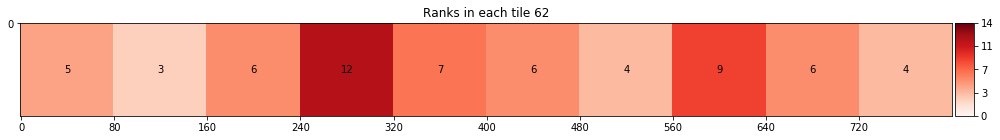

In [16]:
_ = util_plot.cn_ranks_plot(np.array(gpca_ranks),(d1,d2), nblocks=[1,10], figsize=14, fontsize=10)

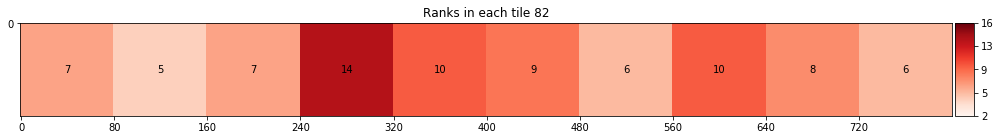

In [17]:
_ = util_plot.cn_ranks_plot(np.array(pmd_ranks), (d1,d2), nblocks=[1,10], figsize=14, fontsize=10)

## Correlation Plots

Local correlation:  range [-1.7e-02 8.6e-01]
Local correlation:  range [-2.8e-01 1.0e+00]
Local correlation:  range [-1.7e-02 1.8e-01]


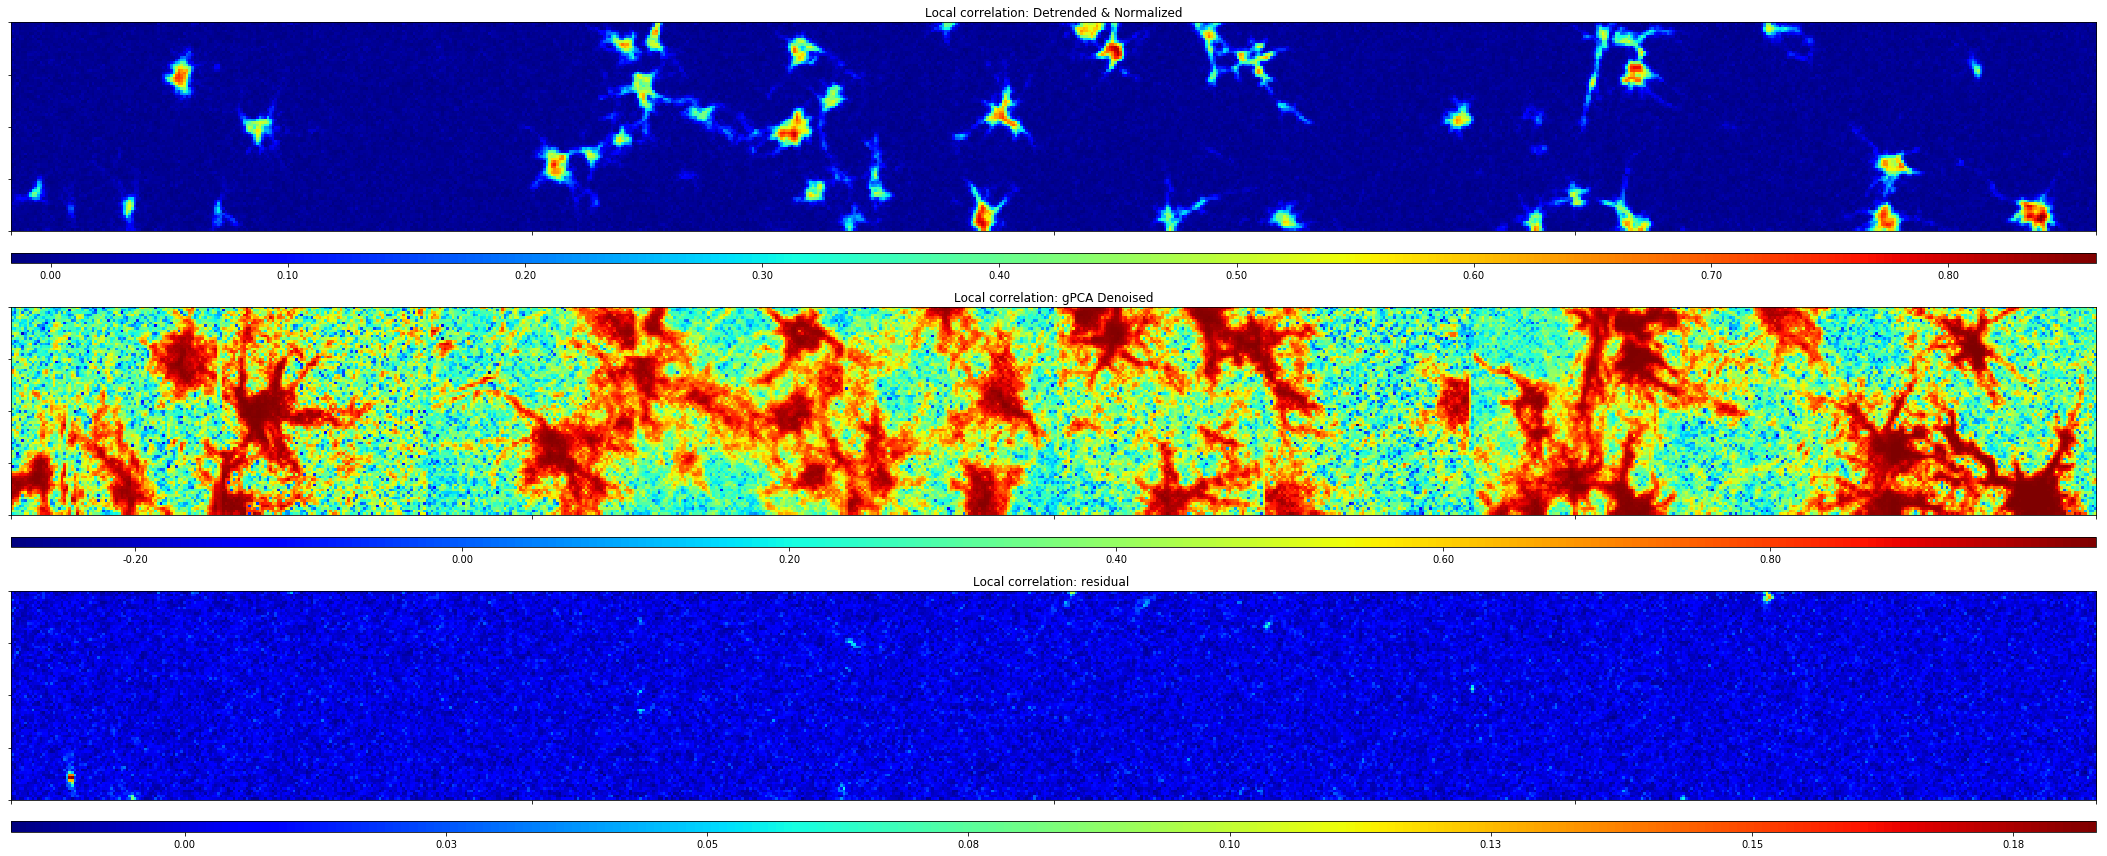

In [18]:
util_plot.comparison_plot([X, gpca_denoised],
                          option='corr',
                          titles_=['Detrended & Normalized', 'gPCA Denoised'],
                          plot_orientation='horizontal',
                          cbar_orientation='horizontal'
                         )

Local correlation:  range [-1.7e-02 8.6e-01]
Local correlation:  range [-2.0e-01 1.0e+00]
Local correlation:  range [-1.7e-02 6.7e-02]


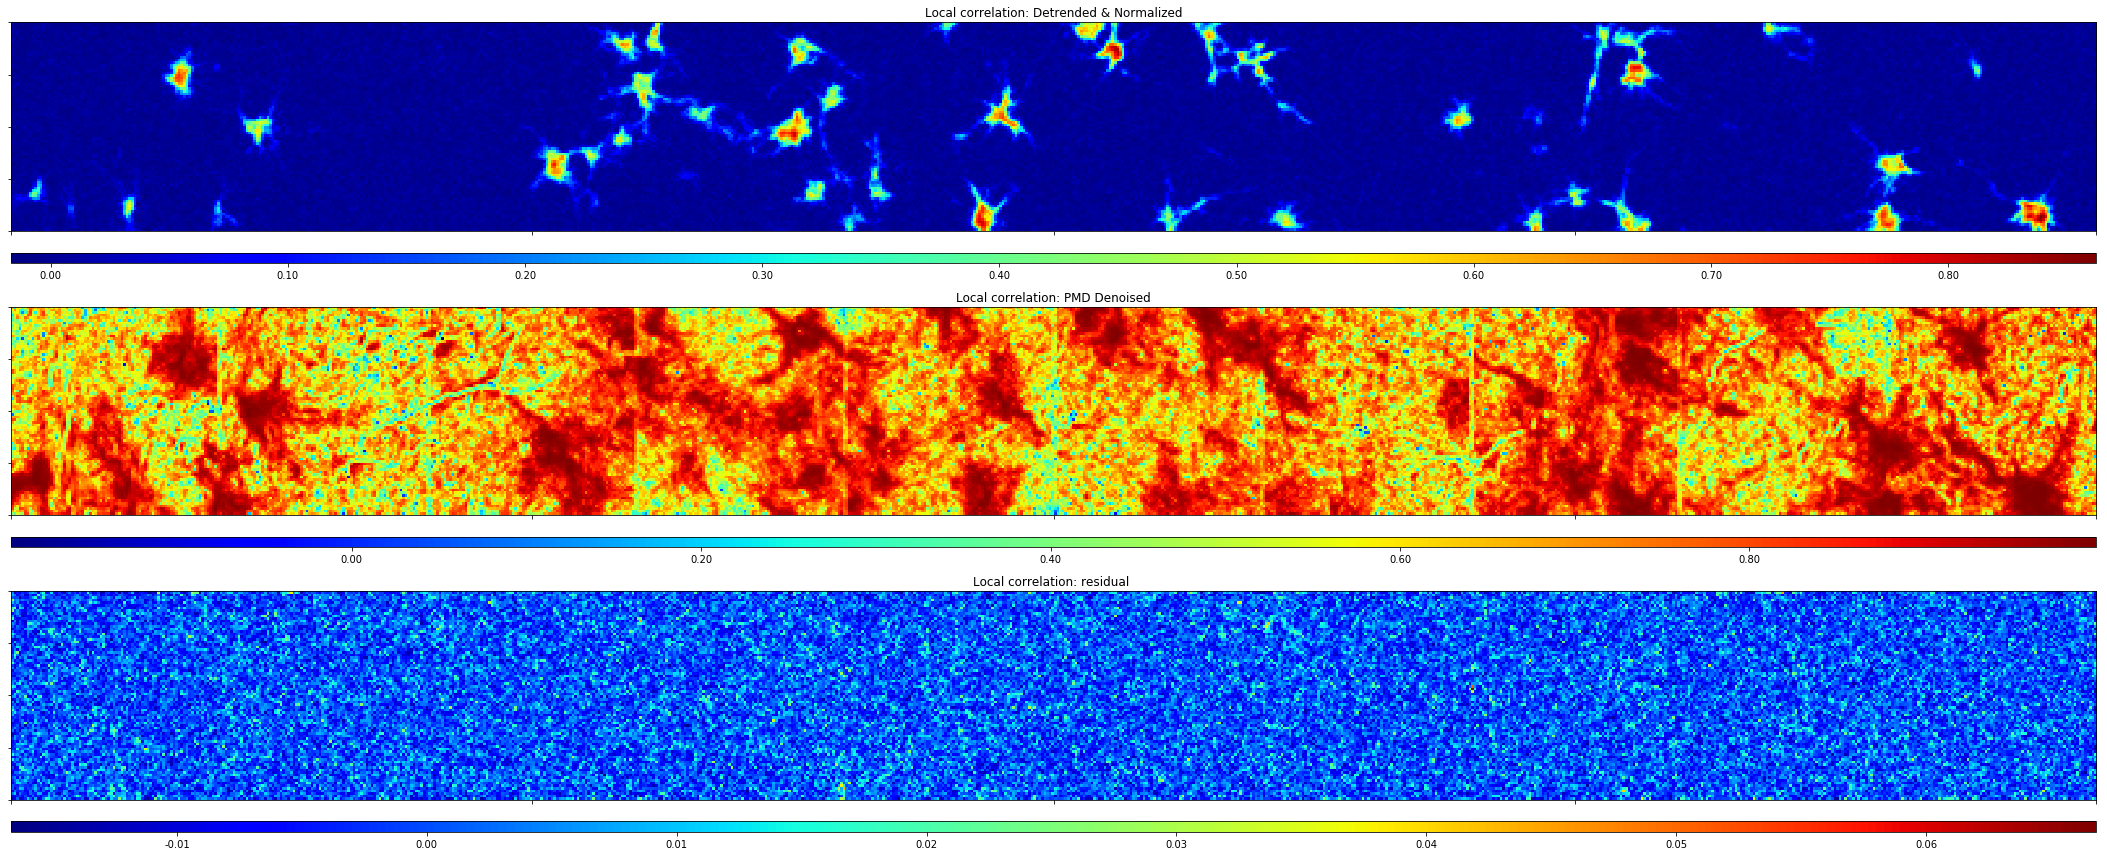

In [19]:
util_plot.comparison_plot([X, pmd_denoised],
                          option='corr',
                          titles_=['Detrended & Normalized', 'PMD Denoised'],
                          plot_orientation='horizontal',
                          cbar_orientation='horizontal'
                         )

## Videos

In [ ]:
#play(np.vstack([X, pmd_denoised, X-pmd_denoised]), magnification=2, gain=3)

In [ ]:
#play(np.vstack([X, gpca_denoised, X-gpca_denoised]), magnification=2, gain=3)

In [ ]:
#play(np.vstack([X - gpca_denoised, gpca_denoised, X, pmd_denoised, X-pmd_denoised]),
#     magnification=2)